# Integrantes:
- Gabriel Fernandes Vieira de Farias

# Introdução

Este notebook tem como objetivo analisar os fatores mais relevantes para um bom filme, utilizando as avaliações dos 250 melhores filmes do IMDB como proxy. A partir dos dados fornecidos, busquei identificar as características que mais contribuem para um filme ser bem avaliado.


# Problema

Quais fatores são mais determinantes para que um filme seja considerado bom pelos críticos e pelo público? Para responder a essa pergunta, analisarei dados sobre nome, classificação, pontuação, quantidade de avaliações, ano de lançamento, duração, diretores, roteiristas e estrelas dos filmes.

# Coleta de Dados

Os dados foram coletados do IMDB top 250 movies, através de web scraping. Depois, inseri os dados em um arquivo Excel com as seguintes colunas: Nome, Classificação, Pontuação, Quantidade de Avaliações, Ano, Duração, Idade, Diretores, Roteiristas e Estrelas.

Abaixo pode ser observado os passos para coleta dos dados

In [212]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
url = 'https://m.imdb.com/chart/top/'

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

req = requests.get(url, headers=header)
bs = BeautifulSoup(req.text, 'html.parser')

In [ ]:
df = pd.DataFrame({ 'Name': [], 'Ranking': [], 'Score': [], 'Review Amount': [], 'Year': [], 'Length': [], 'Rate': [], 'Page Url': [] })

In [ ]:
li_list = bs.find_all('li', { 'class': 'ipc-metadata-list-summary-item' })

for li in li_list:
  h3 = li.find('h3').text
  ranking, title = h3.split('. ', 1)
  score = li.find('span', { 'class':'ipc-rating-star--imdb' })['aria-label'].split(': ')[1]
  reviews_amount = li.find('span', { 'class': 'ipc-rating-star--voteCount' }).text
  metadata = li.find('div', { 'class': 'cli-title-metadata' })
  year = metadata.find_all('span')[0].text
  length = metadata.find_all('span')[1].text
  rate = 'Not Rated'
  if len(metadata.find_all('span')) > 2:
    rate = metadata.find_all('span')[2].text
  
  query = li.find('a', { 'class': 'ipc-title-link-wrapper' })['href'].split('/?')[0]
  page_url = 'https://m.imdb.com' + query

  df.loc[len(df.index)] = [title, ranking, score, reviews_amount, year, length, rate, page_url]


In [ ]:
for i, row in df.iterrows():
  page_url = row['Page Url']
  req = requests.get(page_url, headers=header)
  bs = BeautifulSoup(req.text, 'html.parser')

  container = bs.find('div', { 'class': 'iOESUA' })
  uls = container.find_all('ul', { 'class': 'ipc-inline-list--show-dividers' })
  directors = uls[0].find_all('a', { 'class': 'ipc-metadata-list-item__list-content-item' })
  writers = uls[1].find_all('a', { 'class': 'ipc-metadata-list-item__list-content-item' })
  stars = uls[2].find_all('a', { 'class': 'ipc-metadata-list-item__list-content-item' })

  director = ''
  for director_tag in directors:
    director += director_tag.text + ','
  director = director[:-1]

  writer = ''
  for writer_tag in writers:
    writer += writer_tag.text + ','
  writer = writer[:-1]

  star = ''
  for star_tag in stars:
    star += star_tag.text + ','
  star = star[:-1]

  df.loc[i, 'Directors'] = director
  df.loc[i, 'Writers'] = writer
  df.loc[i, 'Stars'] = star

  print(i, row['Name'])

  time.sleep(0.5)

# Análise

Nesta seção, realizei a análise dos dados para identificar os fatores mais relevantes para um bom filme. Comecei limpando os dados e separando os múltiplos nomes nas colunas de diretores, roteiristas e estrelas.

In [257]:
file_path = 'movies.xlsx'
df = pd.read_excel(file_path)

df.head()

,Name,Ranking,Score,Review Amount,Year,Length,Rate,Page Url,Directors,Writers,Stars
0,Um Sonho de Liberdade,1,9.3,(2.9M),1994,2h 22m,16,https://m.imdb.com/title/tt0111161,Frank Darabont,"Stephen King,Frank Darabont","Tim Robbins,Morgan Freeman,Bob Gunton"
1,O Poderoso Chefão,2,9.2,(2M),1972,2h 55m,14,https://m.imdb.com/title/tt0068646,Francis Ford Coppola,"Mario Puzo,Francis Ford Coppola","Marlon Brando,Al Pacino,James Caan"
2,Batman: O Cavaleiro das Trevas,3,9.0,(2.9M),2008,2h 32m,12,https://m.imdb.com/title/tt0468569,Christopher Nolan,"Jonathan Nolan,Christopher Nolan,David S. Goyer","Christian Bale,Heath Ledger,Aaron Eckhart"
3,O Poderoso Chefão II,4,9.0,(1.4M),1974,3h 22m,14,https://m.imdb.com/title/tt0071562,Francis Ford Coppola,"Francis Ford Coppola,Mario Puzo","Al Pacino,Robert De Niro,Robert Duvall"
4,12 Homens e uma Sentença,5,9.0,(867K),1957,1h 36m,Livre,https://m.imdb.com/title/tt0050083,Sidney Lumet,Reginald Rose,"Henry Fonda,Lee J. Cobb,Martin Balsam"


### Limpeza dos dados

In [258]:
df['Directors'] = df['Directors'].str.split(',')
df['Writers'] = df['Writers'].str.split(',')
df['Stars'] = df['Stars'].str.split(',')

In [259]:
def fix_review_amount(amount_str):
  amount_num = amount_str.strip()[1:-1]

  if("M" in amount_num):
    amount_num = float(amount_num[:-1]) * 1000000
  elif("K" in amount_num):
    amount_num = float(amount_num[:-1]) * 1000

  return amount_num

In [260]:
def fix_length_to_min(length_str):
  duration = 0
  splitted = length_str.split()

  for time in splitted:
    if 'h' in time:
      duration += int(time[:-1]) * 60
    if 'm' in time:
      duration += int(time[:-1])
    

  return duration

In [261]:
def fix_rate(rate_str):
  strs = [
    "Livre",
    "Not Rated",
    "(Banned)",
    "Approved",
    "Passed"
  ]
  
  if(rate_str in strs): return 0

  return int(rate_str)

In [262]:
df['Review Amount'] = df['Review Amount'].apply(fix_review_amount)
df['Length'] = df['Length'].apply(fix_length_to_min)
df['Rate'] = df['Rate'].apply(fix_rate)

### Lidando com variáveis categóricas

In [263]:
directors_dummies = pd.get_dummies(df['Directors'].explode()).groupby(level=0).sum()
writers_dummies = pd.get_dummies(df['Writers'].explode()).groupby(level=0).sum()
stars_dummies = pd.get_dummies(df['Stars'].explode()).groupby(level=0).sum()

df_final = pd.concat([df, directors_dummies, writers_dummies, stars_dummies], axis=1)

### Modelo de Random Forest

In [264]:
to_remove_columns = ['Name', 'Ranking', 'Score', 'Page Url', 'Directors', 'Writers', 'Stars']
features = filter(lambda x: x not in to_remove_columns,
                  df_final.columns.tolist())
features = list(features)

In [265]:
x = df_final[features]
y = df_final['Score']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=43)

In [266]:
rf_model = RandomForestRegressor(n_estimators=500, random_state=43)
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)

In [267]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R2: {r2}')

MSE: 0.02876114399999874
R2: 0.6049293406593588


In [268]:
feature_importances = pd.DataFrame(rf_model.feature_importances_, 
                                   columns=['Importance']).sort_values('Importance', ascending=False)
indexes = feature_importances.index.tolist()[:10]

x_plot = []
y_plot = []

for i in indexes:
  y_plot.append(x.columns[i])
  x_plot.append(feature_importances.loc[i, 'Importance'])

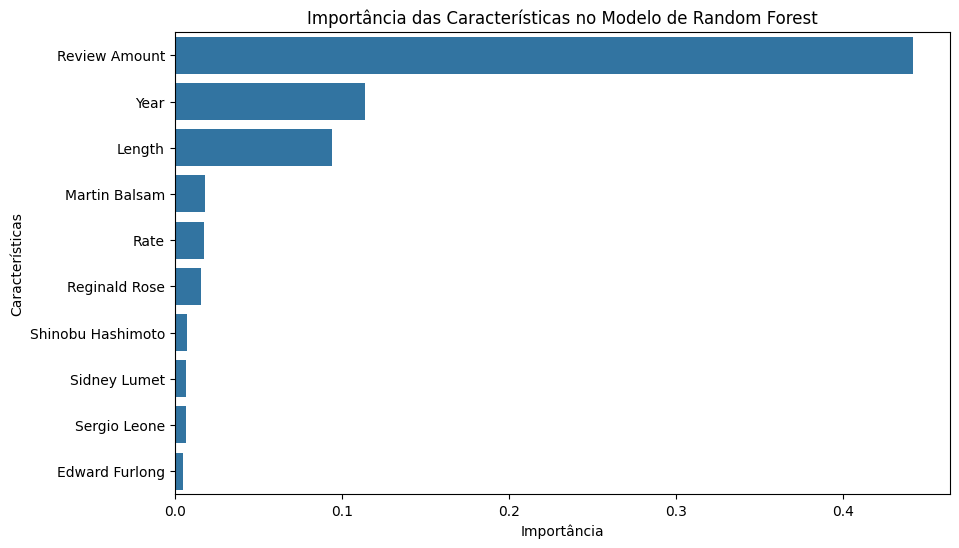

In [269]:
plt.close()
plt.figure(figsize=(10, 6))
sns.barplot(x=x_plot, y=y_plot)
plt.xlabel('Importância')
plt.ylabel('Características')
plt.title('Importância das Características no Modelo de Random Forest')
plt.show()

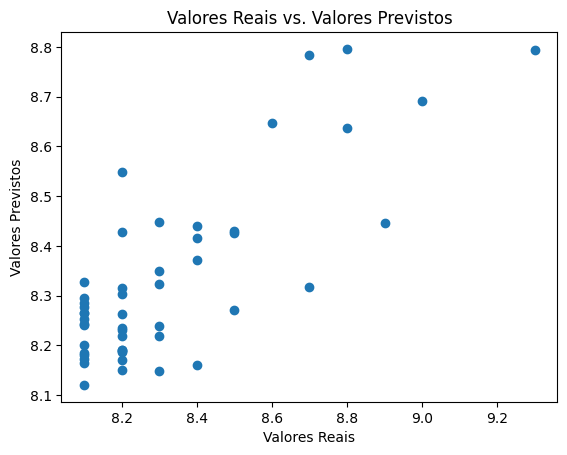

In [270]:
plt.close()
plt.scatter(y_test, y_pred)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.title('Valores Reais vs. Valores Previstos')
plt.show()

Valores abaixo estão em milhares

# Conclusão

Após se obter os resultados do modelo, é possível observar que se obteve um R2 de, aproximadamente 60%, que é relativamente alto, mostrando que esse modelo pode ser um bom preditor para alta qualidade de um filme e um MSE de, aproximadamente, 2.9%, que está dentro do esperado para um modelo de random forest em dados tabulares.

Por outro lado, ao se fazer uma análise das variáveis que compõem o modelo, observa-se que a de maior relevância é o número de avaliações do filme. Isso pode ser um indicativo de que, para que um filme possua alta qualidade, ele precise atingir um alto número de espectadores, o que normalmente é alcançado através de um *budget* alto.

Também se sabe que nem todo filme com alto *budget* é um filme que alcança um alto grau de qualidade. Isso pode ser observado facilmente com os últimos lançamentos da **Marvel**.

Dessa forma, uma boa estratégia para um filme que será lançado em breve é focar no marketing, pois, poderá trazer lucros e, eventualmente, alcançar altas posições em rankings como o da IMDB.